## Andrej's makemore lecture - 3

Implementation following Andrej Karpathy's lecture [Building makemore Part 3: Activations & Gradients, BatchNorm](https://youtu.be/P6sfmUTpUmc).

I have some liberty to refactor and pythonise his implementation.

In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    target_version=black.TargetVersion.PY310,
)

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import display, HTML, clear_output

display(HTML("<style>.container { width:100% !important; }</style>"))


from dataclasses import dataclass, field
import typing as t
import itertools as it
import collections as c
import json
from copy import deepcopy
import math
import time
import functools as ft
import numpy as np
import random
from tqdm.notebook import tqdm
import heapq
import torch as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.tensorboard as tb

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14

In [3]:
# Number of past tokens to use to predict next token
CTX_WIN_SZ = 3

### Load data

In [4]:
DOT = "."
words = open("names.txt").read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

#### Build mapping of character to index

In [5]:
def build_ixes(words):
    chars = [DOT] + sorted(set(it.chain.from_iterable(words)))
    nchars = len(chars)
    ctoix = {c: i for i, c in enumerate(chars)}
    ixtoc = dict(enumerate(chars))
    return (ctoix, ixtoc)

In [6]:
(ctoix, ixtoc) = build_ixes(words)

#### Create training data with context window size

In [7]:
def build_train_data(words, ctoix, ctx_win=CTX_WIN_SZ):
    Xs, Ys = [], []
    pad = DOT * ctx_win
    for wnum, w in enumerate(words):
        pw = pad + w + DOT
        if wnum < 2:
            print(pw)
        for i in range(len(w) + 1):
            if wnum < 2:
                print(pw[i : i + ctx_win], "--->", pw[i + ctx_win])
            Xs.append([ctoix[c] for c in pw[i : i + ctx_win]])
            Ys.append([ctoix[pw[i + ctx_win]]])
    return T.tensor(Xs, dtype=int), T.tensor(Ys, dtype=int).flatten()

In [8]:
Xs, Ys = build_train_data(words, ctoix, ctx_win=CTX_WIN_SZ)
n, m = Xs.shape
n, m

...emma.
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
...olivia.
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .


(228146, 3)

In [9]:
Ys[:30]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9])

#### Train, validation, test split

In [10]:
NCHARS = len(ctoix)
NCHARS

27

In [11]:
ntrain, nval = int(n * 0.8), int(n * 0.1)
ntest = n - ntrain - nval
print(f"{ntrain=}, {nval=}, {ntest=}")
ixes = list(range(0, n))
random.shuffle(ixes)
valend = ntrain + nval
ixtr, ixval, ixtest = ixes[:ntrain], ixes[ntrain:valend], ixes[valend:]

ntrain=182516, nval=22814, ntest=22816


In [12]:
(Xtr, Ytr), (Xval, Yval) = (Xs[ixtr], Ys[ixtr]), (Xs[ixval], Ys[ixval])
(Xtest, Ytest) = (Xs[ixtest], Ys[ixtest])

In [13]:
Xtest, Ytest

(tensor([[ 0,  5, 22],
         [ 0,  0,  0],
         [ 5, 14, 10],
         ...,
         [ 0,  0,  0],
         [21,  4, 19],
         [20, 15, 14]]),
 tensor([15, 10,  1,  ..., 11, 25, 25]))

In [14]:
print(Xtr.shape, Xval.shape, Xtest.shape)

torch.Size([182516, 3]) torch.Size([22814, 3]) torch.Size([22816, 3])


### Model layer implementations

Requires building following layers

- Embedding
- Linear layer
- BatchNorm1D
- Tanh

In [15]:
@dataclass
class Embedding:

    num_embed: int
    embed_dim: int
    E: T.Tensor = field(init=False, repr=False)
    _params: list[T.Tensor] = field(init=False, repr=False)
    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def __post_init__(self):
        self.E = T.randn(self.num_embed, self.embed_dim)
        self._params = [self.E]
        self.parameters = lambda: self._params

    def __call__(self, X):
        batch_sz, num_terms = X.shape
        self.out = self.E[X].view(batch_sz, -1)
        return self.out


@dataclass
class Linear:

    fanin: int
    fanout: int
    bias: bool = True
    # gain used in kaiming he activation
    wt_gain: float = 1.0
    # if not set we use kaiming he activation
    init_wt_scale: t.Optional[float] = None
    b: t.Optional[T.Tensor] = field(init=False, repr=False)
    W: T.Tensor = field(init=False, repr=False)
    _params: list[T.Tensor] = field(init=False, repr=False)
    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def __post_init__(self):
        if self.init_wt_scale is None:
            self.init_wt_scale = self.wt_gain / (self.fanin**0.5)
        # sample from uniform random
        self.W = T.FloatTensor(self.fanin, self.fanout).uniform_(
            -self.init_wt_scale, self.init_wt_scale
        )
        if self.bias:
            self.b = T.ones(1, self.fanout) * 0.01
            self._params = [self.W, self.b]
        else:
            self.b = None
            self._params = [self.W]
        self.parameters = lambda: self._params

    def __call__(self, X):
        if self.bias:
            self.out = X @ self.W + self.b
        else:
            self.out = X @ self.W
        return self.out


@dataclass
class BatchNorm1D:

    size: int
    momentum: float = 0.01
    eps: float = 1e-5
    #: scaling after standardising
    gamma: T.Tensor = field(init=False, repr=False)
    #: shift after standardising
    beta: T.Tensor = field(init=False, repr=False)
    _params: list[T.Tensor] = field(init=False, repr=False)
    #: running averages of mean and variance
    buffer_mean: T.Tensor = field(init=False, repr=False)
    buffer_var: T.Tensor = field(init=False, repr=False)
    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def __post_init__(self):
        self.gamma = T.ones(1, self.size)
        self.beta = T.zeros(1, self.size)
        self._params = [self.gamma, self.beta]
        self.parameters = lambda: self._params
        self.buffer_mean = T.zeros(1, self.size, requires_grad=False)
        self.buffer_var = T.ones(1, self.size, requires_grad=False)

    def __call__(self, X, inference=False):
        fwd_fn = self._fwd_inference if inference else self._fwd_train
        return fwd_fn(X)

    def _fwd_train(self, X):
        mu = X.mean(dim=0, keepdims=True)
        var = X.var(dim=0, keepdims=True) + self.eps
        with T.no_grad():
            mom_old, mom_new = 1 - self.momentum, self.momentum
            self.buffer_mean = mom_old * self.buffer_mean + mom_new * mu
            self.buffer_var = mom_old * self.buffer_var + mom_new * var
        self.out = BatchNorm1D._fwd(
            X=X, mu=mu, var=var, gamma=self.gamma, beta=self.beta
        )
        return self.out

    def _fwd_inference(self, X):
        with T.no_grad():
            self.out = BatchNorm1D._fwd(
                X=X,
                mu=self.buffer_mean,
                var=self.buffer_var,
                gamma=self.gamma,
                beta=self.beta,
            )
            return self.out

    @staticmethod
    def _fwd(X, mu, var, gamma, beta):
        X_std = (X - mu) / T.sqrt(var)
        return (X_std * gamma) + beta


@dataclass
class Tanh:

    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def parameters(self):
        return []

    def __call__(self, X):
        self.out = T.tanh(X)
        return self.out

### Training loop
- Split data into batches
- Fwd pass, zero grad, loss.backward, batch gradient update.
- Keep track of learning losses for later plotting.

In [16]:
def train_loop(
    Xs,
    Ys,
    mdl,
    lr,
    num_iter,
    max_sub_iter=None,
    batch_sz=128,
    losses=None,
    wt_update_ratios=None,
    verbose=True,
):
    # train_ix to loss
    wt_update_ratios = wt_update_ratios if wt_update_ratios is not None else {}
    losses = losses if losses is not None else []
    max_sub_iter = max_sub_iter or np.inf
    nrows = Xs.shape[0]
    ixes = list(range(nrows))
    if verbose:
        itrs = tqdm(range(num_iter))
    else:
        itrs = range(num_iter)
    total_iter = len(losses)
    for i in itrs:
        total_iter += 1
        random.shuffle(ixes)
        for sub_iter, begix in enumerate(
            T.arange(0, nrows, batch_sz), start=1
        ):
            batch_ix = ixes[begix : begix + batch_sz]
            p = fwd_pass(Xs=Xs[batch_ix], mdl=mdl)
            loss = F.cross_entropy(input=p, target=Ys[batch_ix])
            losses.append(loss.item())
            # The output of each layer is an intermediate computation
            # the gradient is only needed for model params. We force
            # pytorch to keep these grads.
            retain_out_grad(mdl)
            _zero_grad(mdl=mdl)
            loss.backward()
            _update_params(
                mdl=mdl,
                lr=_get_lr(lr=lr, it=total_iter),
                wt_update_ratios=wt_update_ratios,
            )
            if sub_iter >= max_sub_iter:
                break
        if verbose:
            itrs.set_description(f"Loss: {loss.item():.2f}")
    return losses


def fwd_pass(Xs, mdl, act_fn=None, return_intermediates=False):
    x = Xs
    for layer in mdl["layers"]:
        x = layer(x)
    return x


def retain_out_grad(mdl):
    for layer in mdl["layers"]:
        layer.out.retain_grad()


def fwd_proba(Xs, mdl, act_fn=None):
    return F.softmax(fwd_pass(Xs=Xs, mdl=mdl, act_fn=act_fn), dim=1)


def _get_lr(lr, it):
    if isinstance(lr, (int, float, T.TensorType, T.Tensor)):
        return lr
    elif isinstance(lr, dict):
        for (min_it, max_it), _lr in lr.items():
            if min_it <= _lr < max_it:
                return _lr
        else:
            raise ValueError(f"Iteration {it} not in any range in {lr}")
    else:
        raise NotImplementedError(
            f"Don't know how to handle learning {lr} of type {type(lr)}"
        )


def _zero_grad(mdl):
    for param in mdl["params"]:
        param.grad = None


def _update_params(mdl, lr, wt_update_ratios):
    lyr_num = 0
    for param in mdl["params"]:
        param.data -= lr * param.grad
        if param.ndim != 2 or param.shape[0] == 1:
            # only pick linear layer, don't choose gradients for batchnorm
            continue
        # weight updates only for W matrices
        lyr_num += 1
        wname = f"W_{lyr_num}"
        ratios = wt_update_ratios.get(wname, [])
        ratios.append(
            ((lr * param.grad).std() / param.data.std()).log10().item()
        )
        wt_update_ratios[wname] = ratios


def _loss(Xs, Ys, mdl):
    logits = fwd_pass(Xs=Xs, mdl=mdl)
    return F.cross_entropy(input=logits, target=Ys).item()


def _plot_losses(losses: list[int]):
    plt.plot(losses)
    plt.title("Loss vs iteration")
    plt.xlabel("Iter")
    plt.ylabel("Cross entropy or NLL loss")
    plt.grid()


@T.no_grad()
def generate_words(mdl, nwords, ctoix, ctx_win=CTX_WIN_SZ, generator=None):
    st_X = _ctx_to_X(ctx_chars=DOT * CTX_WIN_SZ, ctoix=ctoix).repeat(nwords, 1)
    lst_X = st_X
    words = [[] for _ in range(nwords)]
    for i in range(30):
        # print(f"{lst_X=}")
        new_X = T.multinomial(
            input=F.softmax(fwd_pass(lst_X, mdl), dim=1),
            num_samples=1,
            replacement=True,
            generator=generator,
        )
        # print(f"{new_X=}")
        char_added = False
        for w, ix in zip(words, new_X):
            if w and w[-1] == DOT:
                continue
            char_added |= True
            w.append(ixtoc[ix.item()])
        lst_X[:, :-1] = lst_X[:, 1:]
        lst_X[:, -1] = new_X.squeeze()
        # print(f"{lst_X=}\n\n")
        if not char_added:
            break
    return ["".join(w[:-1]) for w in words]


def num_params(mdl):
    return sum(T.numel(param) for param in mdl["params"])


def _ctx_to_X(ctx_chars, ctoix):
    return T.tensor([ctoix[c] for c in ctx_chars]).unsqueeze(dim=0)

#### Train validation and test losses

In [17]:
@T.no_grad()
def _split_loss(Xtr, Ytr, Xval, Yval, Xtest, Ytest, mdl, split):
    match split:
        case "train":
            spl, loss = "Train", _loss(Xtr, Ytr, mdl)
        case "val":
            spl, loss = "Validation", _loss(Xval, Yval, mdl)
        case "test":
            spl, loss = "Test", _loss(Xtest, Ytest, mdl)
        case _:
            raise NotImplementedError("Split should be train, val or test")
    print(f"{spl} loss={loss:.4f}")
    return loss


split_loss = ft.partial(
    _split_loss,
    Xtr=Xtr,
    Ytr=Ytr,
    Xval=Xval,
    Yval=Yval,
    Xtest=Xtest,
    Ytest=Ytest,
)

### Build model by stacking Layers

In [18]:
EMBED_DIM = 5
HIDDEN_DIM = 50
NUM_HIDDEN = 1

In [19]:
def build_model(
    nchrs=NCHARS,
    ctx_win=CTX_WIN_SZ,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_hidden=NUM_HIDDEN,
    lin_wt_gain=1.0,
    init_wt_scale=None,
    batchnorm=False,
):
    assert hidden_dim > 0, "at least one hidden dim is needed"
    lkwrgs = dict(wt_gain=lin_wt_gain, init_wt_scale=init_wt_scale)
    if batchnorm:
        activation_fn = lambda: [BatchNorm1D(size=hidden_dim), Tanh()]
    else:
        activation_fn = lambda: [Tanh()]
    layers = [
        Embedding(num_embed=nchrs, embed_dim=embed_dim),
        Linear(fanin=embed_dim * ctx_win, fanout=hidden_dim, **lkwrgs),
    ] + activation_fn()
    for _ in range(num_hidden - 1):
        layers.extend([Linear(fanin=hidden_dim, fanout=hidden_dim, **lkwrgs)])
        layers.extend(activation_fn())
    if batchnorm:
        layers.append(Linear(fanin=hidden_dim, fanout=nchrs, wt_gain=1.0))
        bn = BatchNorm1D(size=layers[-1].fanout)
        # last layer we scale the gamma not the weights as they are standardised
        bn.gamma *= 0.01
        layers.append(bn)
    else:
        layers.append(Linear(fanin=hidden_dim, fanout=nchrs, wt_gain=0.1))
    params = [p for lyr in layers for p in lyr.parameters()]
    for p in params:
        p.requires_grad = True
    lyrs_str = "\n\t".join(str(l) for l in layers)
    print(f"Layers: \n\t{lyrs_str}")
    return dict(layers=layers, params=params)

### Test if it works and try to overfit

In [20]:
mdl = build_model(num_hidden=1, lin_wt_gain=5 / 3, batchnorm=True)
Xtr_sml, Ytr_sml = Xtr[:50], Ytr[:50]

Layers: 
	Embedding(num_embed=27, embed_dim=5)
	Linear(fanin=15, fanout=50, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.43033148291193524)
	BatchNorm1D(size=50, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=50, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.1414213562373095)
	BatchNorm1D(size=27, momentum=0.01, eps=1e-05)


In [21]:
losses = []

  0%|          | 0/500 [00:00<?, ?it/s]

We expect this to be large as we overfitted on a small batch.
Train loss=5.7498
Validation loss=5.7456


5.745565414428711

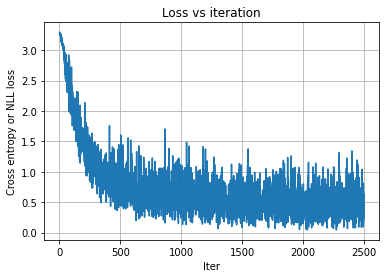

In [22]:
train_loop(
    Xs=Xtr_sml,
    Ys=Ytr_sml,
    mdl=mdl,
    lr=0.1,
    num_iter=500,
    losses=losses,
    batch_sz=10,
)
_plot_losses(losses[:])
print("We expect this to be large as we overfitted on a small batch.")
split_loss(mdl=mdl, split="train")
split_loss(mdl=mdl, split="val")

### Train on all data

In [23]:
def _plot_epoch_losses(ep_train_loss, ep_val_loss):
    plt.figure(figsize=(15, 4))
    for losses, split_nm, snum in [
        (ep_train_loss, "train", 121),
        (ep_val_loss, "validation", 122),
    ]:
        plt.subplot(snum)
        plt.plot(losses)
        plt.xlabel("Iter")
        plt.ylabel("Loss")
        plt.title(f"Epoch {split_nm} losses")
        plt.grid()
    plt.tight_layout()

In [24]:
mdl = build_model(
    num_hidden=1,
    lin_wt_gain=5 / 3,
    hidden_dim=128,
    embed_dim=100,
    batchnorm=True,
)
print(f"\nNumber of model params: {num_params(mdl):,}")
losses = []
ep_train_loss, ep_val_loss = [], []

Layers: 
	Embedding(num_embed=27, embed_dim=100)
	Linear(fanin=300, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.09622504486493762)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.08838834764831843)
	BatchNorm1D(size=27, momentum=0.01, eps=1e-05)

Number of model params: 45,021


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train loss=2.1794
Validation loss=2.2245


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss=2.1118
Validation loss=2.1639


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss=2.0800
Validation loss=2.1374


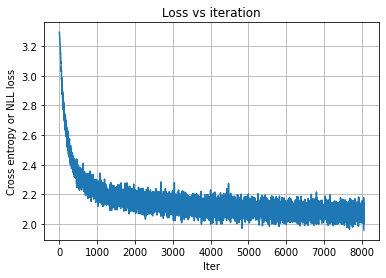

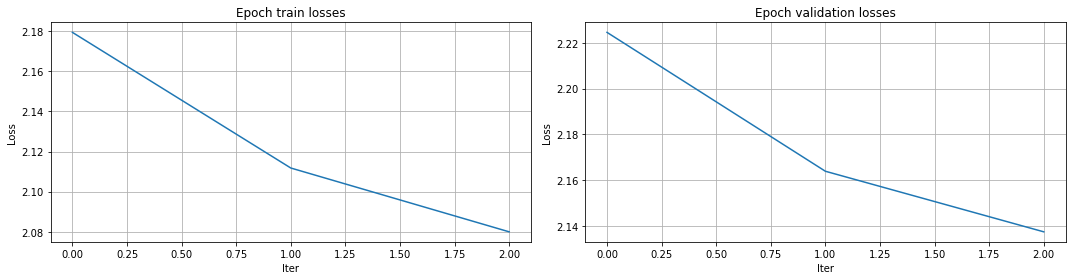

In [25]:
for lr in tqdm(range(3)):
    train_loop(
        Xs=Xtr,
        Ys=Ytr,
        mdl=mdl,
        lr={(0, 15): 0.1, (15, 30): 0.05, (30, np.inf): 0.01},
        num_iter=15,
        losses=losses,
        batch_sz=1024,
        verbose=True,
    )
    ep_train_loss.append(split_loss(mdl=mdl, split="train"))
    ep_val_loss.append(split_loss(mdl=mdl, split="val"))
_plot_losses(losses[:])
_plot_epoch_losses(ep_train_loss, ep_val_loss)

## Diagnostics

#### Plot the activations of the tanh layer with different initialisations/batchnorm 

In [26]:
e = Embedding(num_embed=27, embed_dim=EMBED_DIM)

In [27]:
xs = e(X=Xval[:200])

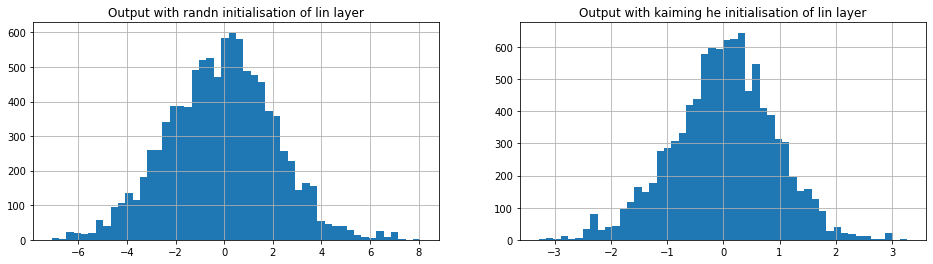

In [28]:
simple_ln = Linear(
    fanin=xs.shape[1], init_wt_scale=1.0, fanout=HIDDEN_DIM, bias=False
)
km_ln = Linear(fanin=xs.shape[1], wt_gain=5 / 3, fanout=HIDDEN_DIM, bias=False)
lx = simple_ln(xs)
kx = km_ln(xs)

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title("Output with randn initialisation of lin layer")
plt.hist(lx.view(-1).tolist(), 50)
plt.grid()

plt.subplot(122)
plt.title("Output with kaiming he initialisation of lin layer")
plt.hist(kx.view(-1).tolist(), 50)
plt.grid()

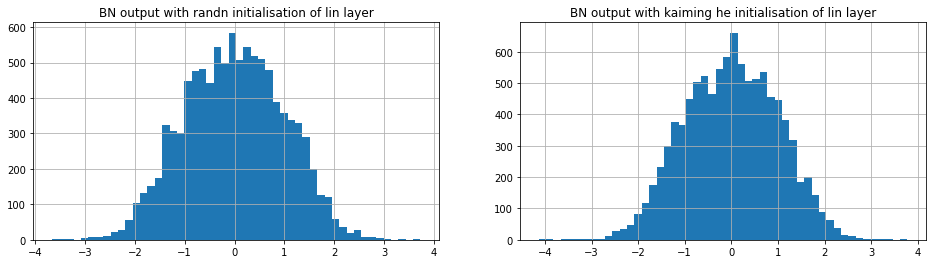

In [29]:
bn = BatchNorm1D(size=HIDDEN_DIM)

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title("BN output with randn initialisation of lin layer")
plt.hist(bn(lx).view(-1).tolist(), 50)
plt.grid()

plt.subplot(122)
plt.title("BN output with kaiming he initialisation of lin layer")
plt.hist(bn(kx).view(-1).tolist(), 50)
plt.grid()

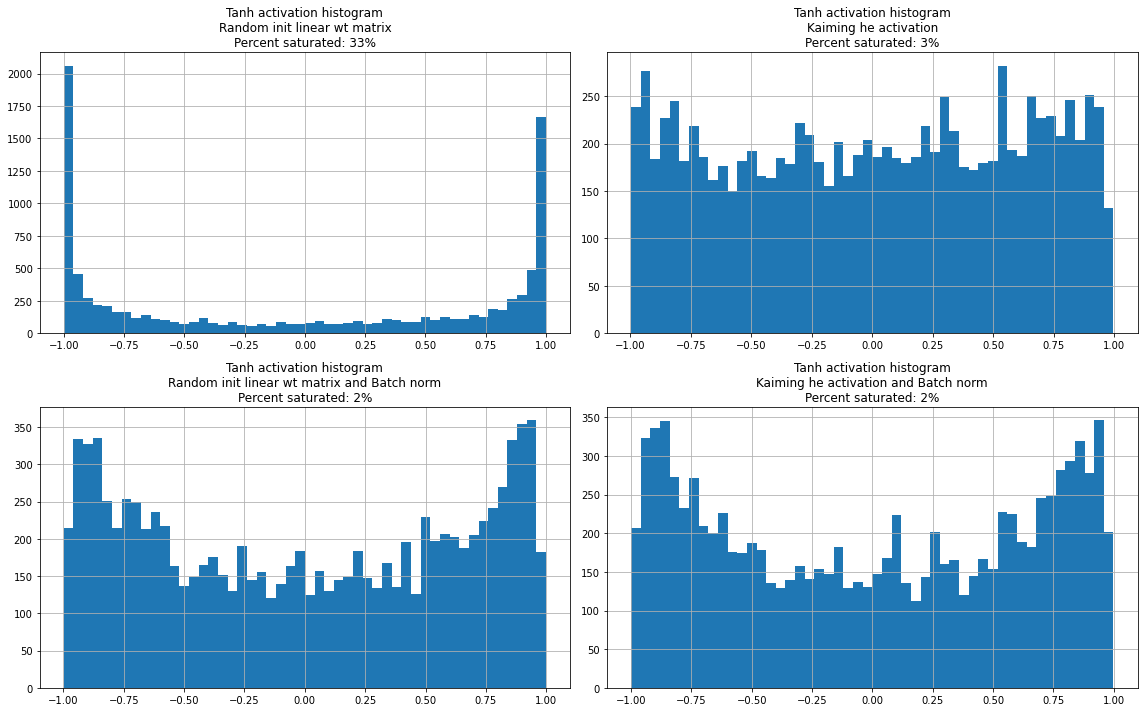

In [30]:
tanh = Tanh()

plt.figure(figsize=(16, 10))
for a, fnum, title in [
    (tanh(lx), 221, "Random init linear wt matrix"),
    (tanh(kx), 222, "Kaiming he activation"),
    (tanh(bn(lx)), 223, "Random init linear wt matrix and Batch norm"),
    (tanh(bn(kx)), 224, "Kaiming he activation and Batch norm"),
]:
    plt.subplot(fnum)
    plt.hist(a.view(-1).tolist(), 50)
    pct_sat = (a.abs() > 0.97).float().mean() * 100.0
    plt.title(
        f"Tanh activation histogram\n{title}\nPercent saturated: {pct_sat:.0f}%"
    )
    plt.grid()
plt.tight_layout()
plt.savefig(
    "/Users/vispers/work/github/psvishnu91.github.io/assets/Images/posts/ml_notes/backprop/bnorm.png"
)

### Experiments

Plot 
- Activations at tanh
- Gradients at tanh
- Gradient.std()/data.std() hist
- Update.std()/data.std() hist


See [youtube video](https://youtu.be/P6sfmUTpUmc?t=5211) (linked to specific time).

In [31]:
def hist_actvns(mdl):
    """Plot the histogram of activations after tanh layer"""

    def act_extract(layer, lyr_num):
        t = layer.out.data
        print(
            f"Layer: {lyr_num} \t| {layer.__class__.__name__} \t| mean: {t.mean():.3f} \t| "
            f"std: {t.std():.3f} \t| Percent saturated: {(t.abs() > 0.97).float().mean()*100.:.0f}%"
        )
        return t

    print("\nActivations:")
    _hist_layer_partial(
        mdl=mdl,
        title="Histogram of Tanh layer output values",
        data_extract_fn=act_extract,
        layer_class=Tanh,
    )


def _hist_layer_partial(mdl, title, data_extract_fn, layer_class):
    plt.figure(figsize=(15, 4))
    legend = []
    for lyr_num, layer in enumerate(mdl["layers"], start=1):
        if not isinstance(layer, layer_class):
            continue
        t = data_extract_fn(layer=layer, lyr_num=lyr_num)
        hist, bin_edges = T.histogram(t, density=True)
        plt.plot(bin_edges[:-1].detach(), hist.tolist())
        legend.append(f"Layer: {lyr_num}")
    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel("Fraction of values")
    plt.grid()
    plt.legend(legend)


def hist_actvn_grads(mdl):
    """Plot the histogram of gradient of the activations after tanh"""

    def grad_extract(layer, lyr_num):
        t = layer.out.grad
        print(
            f"Layer: {lyr_num} \t| {layer.__class__.__name__} \t| mean: {t.mean():.7f} \t| "
            f"std: {t.std():.5f}"
        )
        return t

    print("\nActivation gradients:")
    _hist_layer_partial(
        mdl=mdl,
        title="Histogram of Tanh layer gradients",
        data_extract_fn=grad_extract,
        layer_class=Tanh,
    )


def hist_weight_grads(mdl):
    """Plot the histogram of weights of linear layer"""

    def weight_grad_ratio(layer, lyr_num):
        t = layer.W.grad
        print(
            f"Layer: {lyr_num} \t| \t W {tuple(t.shape)} \t|  {layer.__class__.__name__} "
            f"\t| grad mean: {t.mean():.5f} \t| grad std: {t.std():.5f} \t| "
            f"grad/data ratio: {t.std()/layer.W.std():.4f}"
        )
        return t

    print("\nWeight gradients:")
    _hist_layer_partial(
        mdl=mdl,
        title="Histogram of W.grad.std()",
        data_extract_fn=weight_grad_ratio,
        layer_class=Linear,
    )


def plot_update_ratio(wt_update_ratios):
    """Plot ratio of update.std() to the weight.std() over iterations of training"""
    num_iters = None
    plt.figure(figsize=(15, 4))
    for ratios in wt_update_ratios.values():
        plt.plot(ratios)
        num_iters = len(ratios)
    plt.grid()
    plt.xlabel("Iterations")
    plt.ylabel("Log10 update ratio")
    plt.legend(wt_update_ratios.keys())
    plt.plot([0, num_iters], [-3, -3], color="k")
    plt.title(
        "Plot of the ratio of the scale of weight updates over the scale of the weights \n"
        r"$\log10 \dfrac{ lr \times W.grad.std()}{W.data.std()}$"
    )

In [32]:
def experiment(
    lr=0.1,
    lin_wt_gain=5 / 3,
    init_wt_scale=None,
    max_sub_iter=np.inf,
    batchnorm=False,
    num_hidden=4,
    num_iter=10,
):
    mdl = build_model(
        num_hidden=num_hidden,
        init_wt_scale=init_wt_scale,
        lin_wt_gain=lin_wt_gain,
        hidden_dim=128,
        embed_dim=100,
        batchnorm=batchnorm,
    )
    print(f"\nNumber of model params: {num_params(mdl):,}")
    losses, wt_update_ratios = [], {}
    train_loop(
        Xs=Xtr,
        Ys=Ytr,
        mdl=mdl,
        lr=lr,  # {(0, 15): 0.1, (15, 30): 0.05, (30, np.inf): 0.01},
        num_iter=num_iter,
        losses=losses,
        batch_sz=1024,
        verbose=True,
        max_sub_iter=max_sub_iter,
        wt_update_ratios=wt_update_ratios,
    )
    hist_actvns(mdl)
    print()
    hist_actvn_grads(mdl)
    print()
    hist_weight_grads(mdl)
    print()
    plot_update_ratio(wt_update_ratios)
    print()

In [33]:
disp = lambda x: display(HTML(x))

Layers: 
	Embedding(num_embed=27, embed_dim=100)
	Linear(fanin=300, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.09622504486493762)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.1473139127471974)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.1473139127471974)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.1473139127471974)
	Tanh()
	Linear(fanin=128, fanout=27, bias=True, wt_gain=0.1, init_wt_scale=0.008838834764831844)

Number of model params: 94,247


  0%|          | 0/10 [00:00<?, ?it/s]


Activations:
Layer: 3 	| Tanh 	| mean: 0.028 	| std: 0.706 	| Percent saturated: 10%
Layer: 5 	| Tanh 	| mean: 0.019 	| std: 0.555 	| Percent saturated: 0%
Layer: 7 	| Tanh 	| mean: 0.024 	| std: 0.509 	| Percent saturated: 0%
Layer: 9 	| Tanh 	| mean: 0.009 	| std: 0.550 	| Percent saturated: 0%


Activation gradients:
Layer: 3 	| Tanh 	| mean: -0.0000066 	| std: 0.00055
Layer: 5 	| Tanh 	| mean: 0.0000028 	| std: 0.00051
Layer: 7 	| Tanh 	| mean: 0.0000017 	| std: 0.00042
Layer: 9 	| Tanh 	| mean: 0.0000010 	| std: 0.00032


Weight gradients:
Layer: 2 	| 	 W (300, 128) 	|  Linear 	| grad mean: -0.00004 	| grad std: 0.00531 	| grad/data ratio: 0.0908
Layer: 4 	| 	 W (128, 128) 	|  Linear 	| grad mean: 0.00001 	| grad std: 0.00422 	| grad/data ratio: 0.0481
Layer: 6 	| 	 W (128, 128) 	|  Linear 	| grad mean: 0.00000 	| grad std: 0.00288 	| grad/data ratio: 0.0326
Layer: 8 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00000 	| grad std: 0.00206 	| grad/data ratio: 0.0229
Layer: 10 	| 	

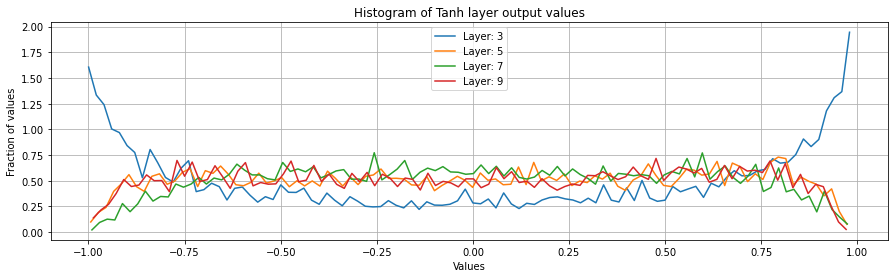

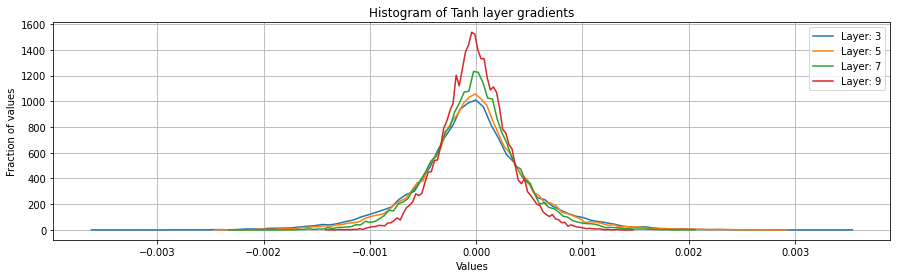

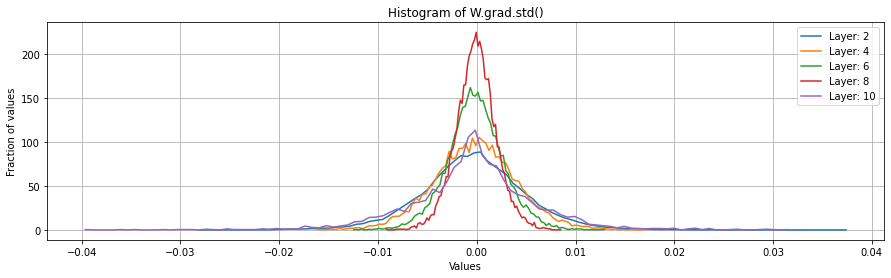

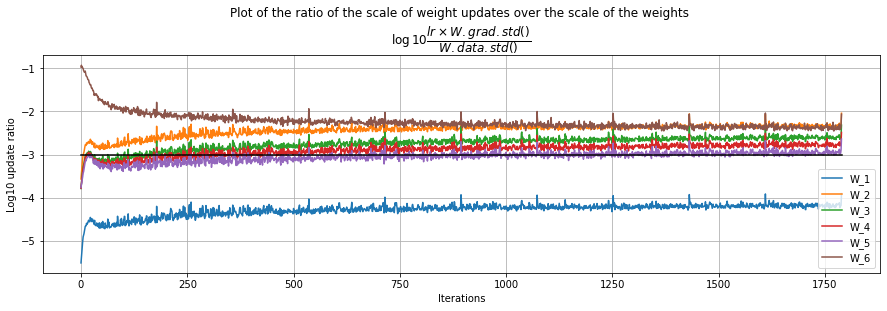

In [34]:
disp("<h3>Kaiming He initialisation with correct tanh gain 5/3</h3>")
experiment(
    lr=0.1,
    lin_wt_gain=5 / 3,
    init_wt_scale=None,
    max_sub_iter=np.inf,
    batchnorm=False,
)

Layers: 
	Embedding(num_embed=27, embed_dim=100)
	Linear(fanin=300, fanout=128, bias=True, wt_gain=10, init_wt_scale=0.5773502691896257)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=10, init_wt_scale=0.8838834764831843)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=10, init_wt_scale=0.8838834764831843)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=10, init_wt_scale=0.8838834764831843)
	Tanh()
	Linear(fanin=128, fanout=27, bias=True, wt_gain=0.1, init_wt_scale=0.008838834764831844)

Number of model params: 94,247


  0%|          | 0/10 [00:00<?, ?it/s]


Activations:
Layer: 3 	| Tanh 	| mean: 0.019 	| std: 0.934 	| Percent saturated: 73%
Layer: 5 	| Tanh 	| mean: -0.007 	| std: 0.925 	| Percent saturated: 69%
Layer: 7 	| Tanh 	| mean: 0.048 	| std: 0.930 	| Percent saturated: 70%
Layer: 9 	| Tanh 	| mean: 0.009 	| std: 0.933 	| Percent saturated: 70%


Activation gradients:
Layer: 3 	| Tanh 	| mean: -0.0000061 	| std: 0.00173
Layer: 5 	| Tanh 	| mean: -0.0000038 	| std: 0.00100
Layer: 7 	| Tanh 	| mean: -0.0000024 	| std: 0.00061
Layer: 9 	| Tanh 	| mean: -0.0000038 	| std: 0.00038


Weight gradients:
Layer: 2 	| 	 W (300, 128) 	|  Linear 	| grad mean: -0.00006 	| grad std: 0.00792 	| grad/data ratio: 0.0237
Layer: 4 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00001 	| grad std: 0.00440 	| grad/data ratio: 0.0086
Layer: 6 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00001 	| grad std: 0.00252 	| grad/data ratio: 0.0049
Layer: 8 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00002 	| grad std: 0.00157 	| grad/data ratio: 0.0031
Layer

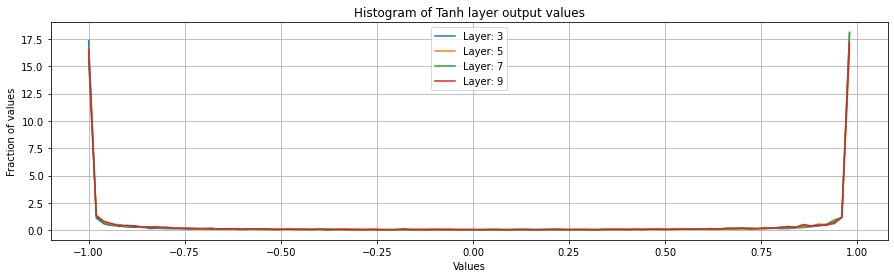

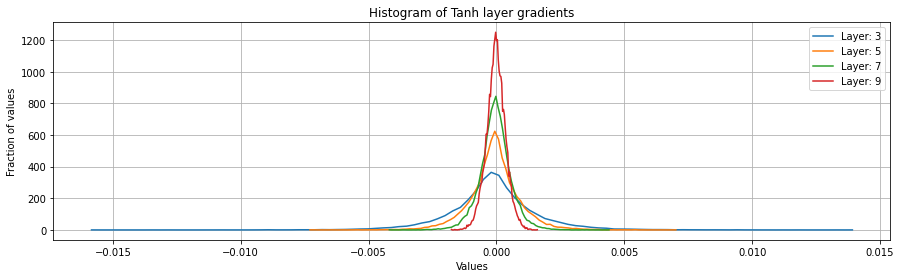

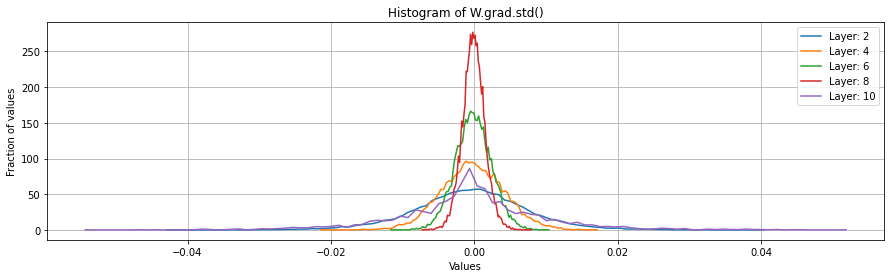

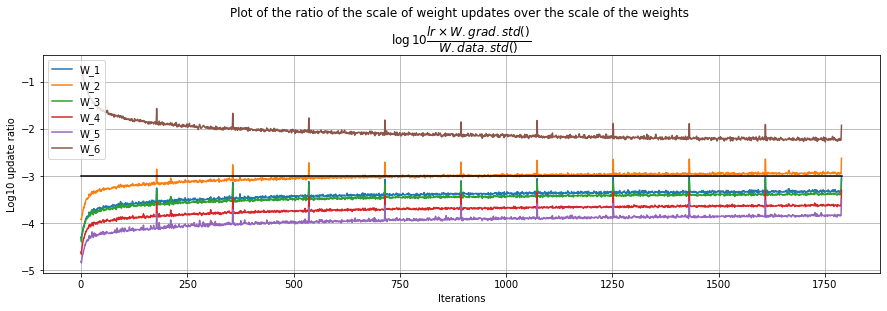

In [35]:
disp("<h3>Kaiming He initialisation with high gain 10</h3>")
experiment(
    lr=0.1,
    lin_wt_gain=10,
    init_wt_scale=None,
    max_sub_iter=np.inf,
    batchnorm=False,
)

Layers: 
	Embedding(num_embed=27, embed_dim=100)
	Linear(fanin=300, fanout=128, bias=True, wt_gain=0.5, init_wt_scale=0.028867513459481284)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=0.5, init_wt_scale=0.044194173824159216)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=0.5, init_wt_scale=0.044194173824159216)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=0.5, init_wt_scale=0.044194173824159216)
	Tanh()
	Linear(fanin=128, fanout=27, bias=True, wt_gain=0.1, init_wt_scale=0.008838834764831844)

Number of model params: 94,247


  0%|          | 0/10 [00:00<?, ?it/s]


Activations:
Layer: 3 	| Tanh 	| mean: 0.008 	| std: 0.502 	| Percent saturated: 2%
Layer: 5 	| Tanh 	| mean: -0.010 	| std: 0.286 	| Percent saturated: 0%
Layer: 7 	| Tanh 	| mean: 0.016 	| std: 0.289 	| Percent saturated: 0%
Layer: 9 	| Tanh 	| mean: 0.117 	| std: 0.347 	| Percent saturated: 0%


Activation gradients:
Layer: 3 	| Tanh 	| mean: -0.0000029 	| std: 0.00041
Layer: 5 	| Tanh 	| mean: -0.0000113 	| std: 0.00034
Layer: 7 	| Tanh 	| mean: -0.0000124 	| std: 0.00027
Layer: 9 	| Tanh 	| mean: -0.0000081 	| std: 0.00022


Weight gradients:
Layer: 2 	| 	 W (300, 128) 	|  Linear 	| grad mean: 0.00004 	| grad std: 0.00641 	| grad/data ratio: 0.2944
Layer: 4 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00002 	| grad std: 0.00369 	| grad/data ratio: 0.1236
Layer: 6 	| 	 W (128, 128) 	|  Linear 	| grad mean: 0.00007 	| grad std: 0.00150 	| grad/data ratio: 0.0497
Layer: 8 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00000 	| grad std: 0.00117 	| grad/data ratio: 0.0376
Layer: 10 	

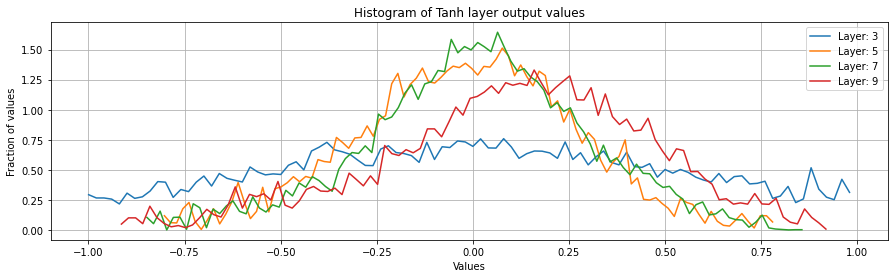

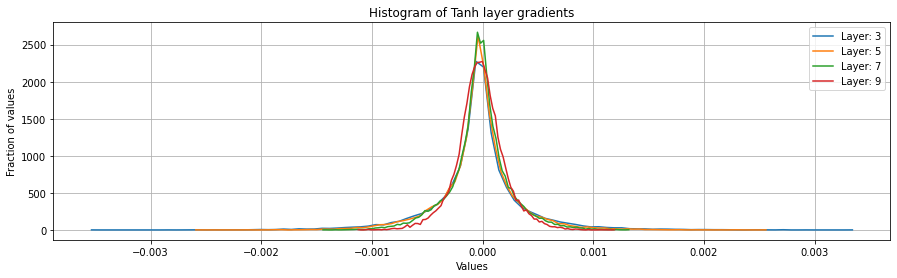

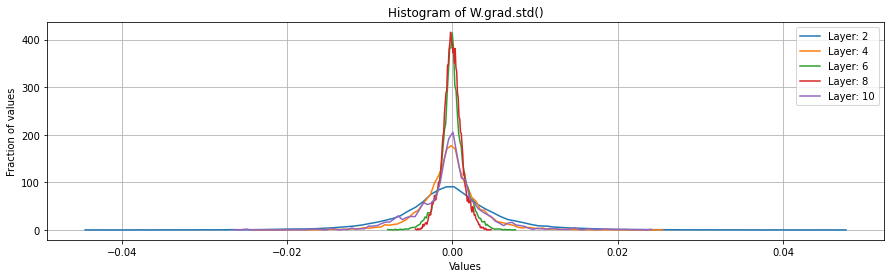

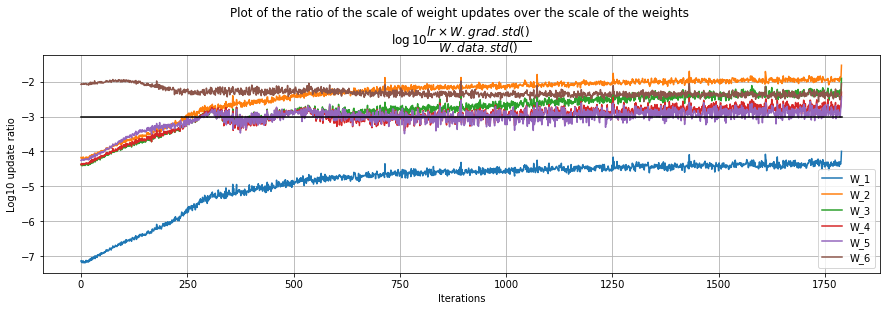

In [36]:
disp("<h3>Kaiming He initialisation with low gain 0.5</h3>")
experiment(
    lr=0.1,
    lin_wt_gain=0.5,
    init_wt_scale=None,
    max_sub_iter=np.inf,
    batchnorm=False,
)

Layers: 
	Embedding(num_embed=27, embed_dim=100)
	Linear(fanin=300, fanout=128, bias=True, wt_gain=1.0, init_wt_scale=1.0)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.0, init_wt_scale=1.0)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.0, init_wt_scale=1.0)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.0, init_wt_scale=1.0)
	Tanh()
	Linear(fanin=128, fanout=27, bias=True, wt_gain=0.1, init_wt_scale=0.008838834764831844)

Number of model params: 94,247


  0%|          | 0/10 [00:00<?, ?it/s]


Activations:
Layer: 3 	| Tanh 	| mean: 0.003 	| std: 0.962 	| Percent saturated: 84%
Layer: 5 	| Tanh 	| mean: 0.012 	| std: 0.935 	| Percent saturated: 73%
Layer: 7 	| Tanh 	| mean: 0.009 	| std: 0.943 	| Percent saturated: 74%
Layer: 9 	| Tanh 	| mean: 0.022 	| std: 0.944 	| Percent saturated: 75%


Activation gradients:
Layer: 3 	| Tanh 	| mean: 0.0000002 	| std: 0.00183
Layer: 5 	| Tanh 	| mean: -0.0000014 	| std: 0.00102
Layer: 7 	| Tanh 	| mean: -0.0000069 	| std: 0.00062
Layer: 9 	| Tanh 	| mean: 0.0000047 	| std: 0.00038


Weight gradients:
Layer: 2 	| 	 W (300, 128) 	|  Linear 	| grad mean: -0.00004 	| grad std: 0.00642 	| grad/data ratio: 0.0111
Layer: 4 	| 	 W (128, 128) 	|  Linear 	| grad mean: 0.00004 	| grad std: 0.00418 	| grad/data ratio: 0.0072
Layer: 6 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00002 	| grad std: 0.00232 	| grad/data ratio: 0.0040
Layer: 8 	| 	 W (128, 128) 	|  Linear 	| grad mean: 0.00001 	| grad std: 0.00146 	| grad/data ratio: 0.0025
Layer: 10 

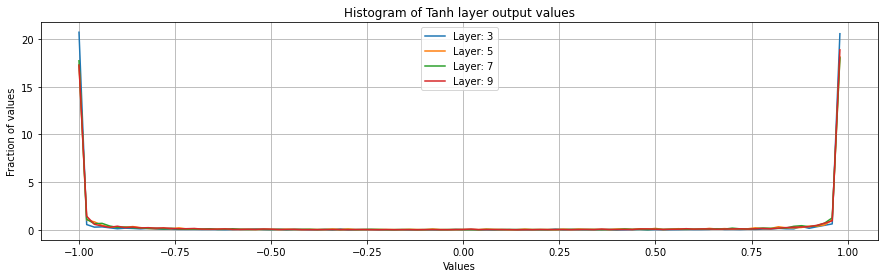

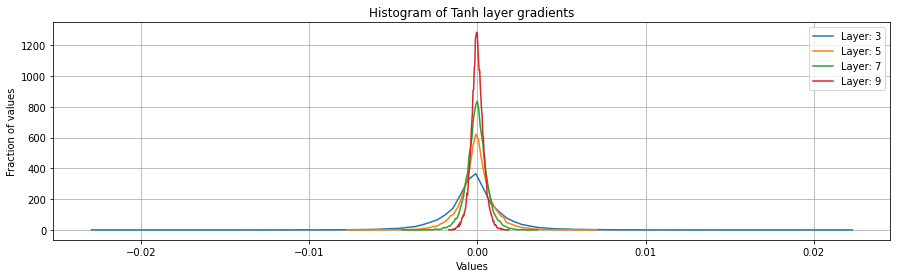

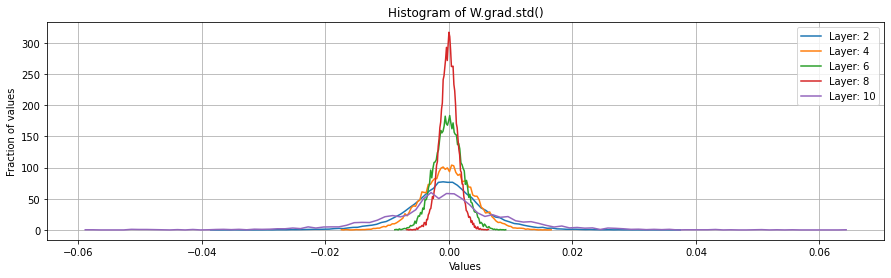

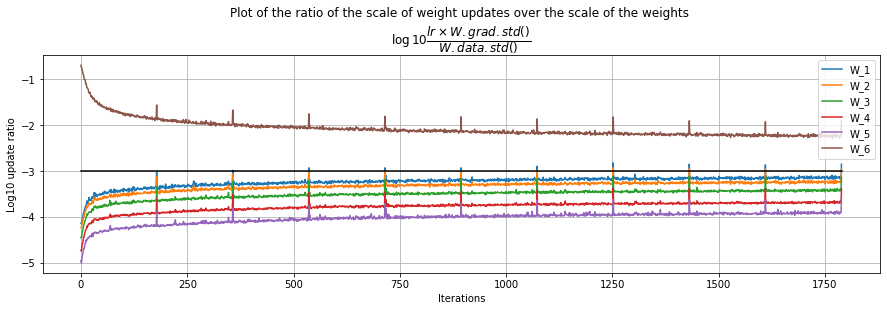

In [37]:
disp("<h3>Simple randn weight initialisation</h3>")
experiment(
    lr=0.1,
    lin_wt_gain=1.0,
    init_wt_scale=1.0,
    max_sub_iter=np.inf,
    batchnorm=False,
    num_iter=10,
)

Layers: 
	Embedding(num_embed=27, embed_dim=100)
	Linear(fanin=300, fanout=128, bias=True, wt_gain=1.0, init_wt_scale=1.0)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.0, init_wt_scale=1.0)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.0, init_wt_scale=1.0)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.0, init_wt_scale=1.0)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.08838834764831843)
	BatchNorm1D(size=27, momentum=0.01, eps=1e-05)

Number of model params: 95,325


  0%|          | 0/10 [00:00<?, ?it/s]


Activations:
Layer: 4 	| Tanh 	| mean: 0.012 	| std: 0.622 	| Percent saturated: 3%
Layer: 7 	| Tanh 	| mean: 0.011 	| std: 0.642 	| Percent saturated: 4%
Layer: 10 	| Tanh 	| mean: -0.011 	| std: 0.653 	| Percent saturated: 5%
Layer: 13 	| Tanh 	| mean: 0.015 	| std: 0.668 	| Percent saturated: 7%


Activation gradients:
Layer: 4 	| Tanh 	| mean: 0.0000000 	| std: 0.00100
Layer: 7 	| Tanh 	| mean: 0.0000000 	| std: 0.00090
Layer: 10 	| Tanh 	| mean: 0.0000000 	| std: 0.00081
Layer: 13 	| Tanh 	| mean: 0.0000000 	| std: 0.00064


Weight gradients:
Layer: 2 	| 	 W (300, 128) 	|  Linear 	| grad mean: 0.00000 	| grad std: 0.00093 	| grad/data ratio: 0.0016
Layer: 5 	| 	 W (128, 128) 	|  Linear 	| grad mean: 0.00001 	| grad std: 0.00139 	| grad/data ratio: 0.0024
Layer: 8 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00000 	| grad std: 0.00129 	| grad/data ratio: 0.0022
Layer: 11 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00000 	| grad std: 0.00113 	| grad/data ratio: 0.0020
Layer: 14 

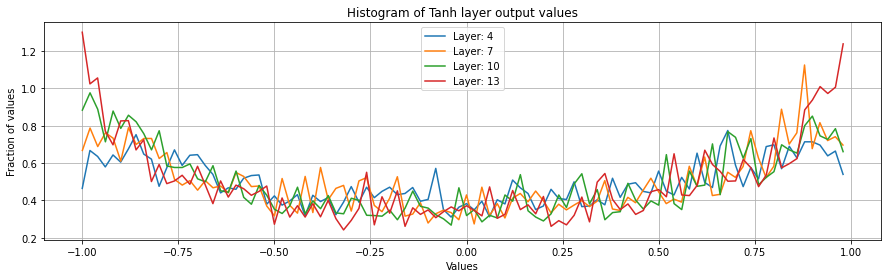

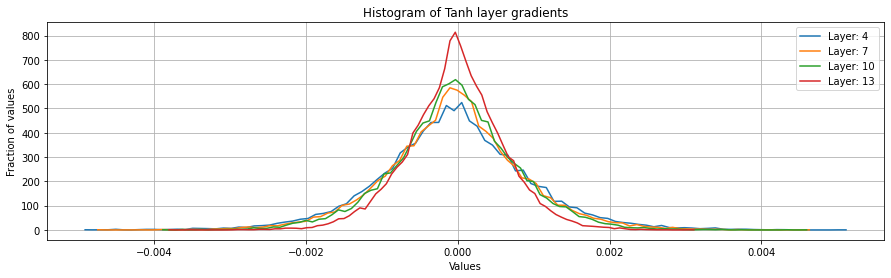

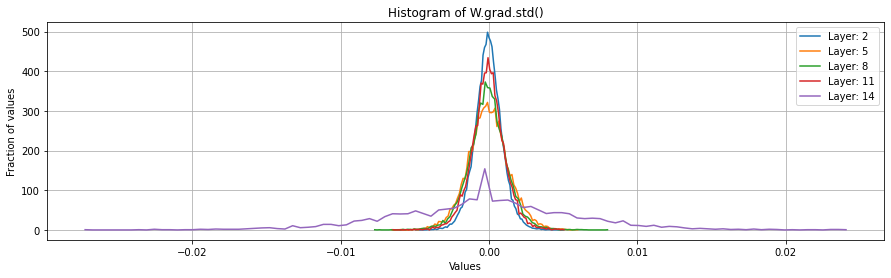

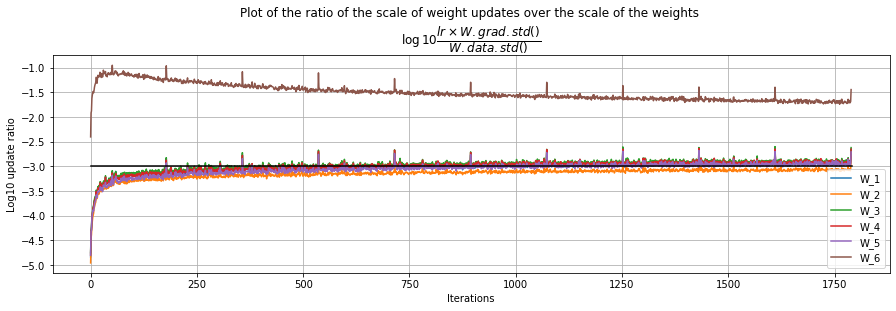

In [38]:
disp("<h3>Randn weights but with batch norm</h3>")
experiment(
    lr=1,
    lin_wt_gain=1.0,
    init_wt_scale=1.0,
    max_sub_iter=np.inf,
    batchnorm=True,
    num_iter=10,
)

Layers: 
	Embedding(num_embed=27, embed_dim=100)
	Linear(fanin=300, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.09622504486493762)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.1473139127471974)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.1473139127471974)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=128, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.1473139127471974)
	BatchNorm1D(size=128, momentum=0.01, eps=1e-05)
	Tanh()
	Linear(fanin=128, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.08838834764831843)
	BatchNorm1D(size=27, momentum=0.01, eps=1e-05)

Number of model params: 95,325


  0%|          | 0/10 [00:00<?, ?it/s]


Activations:
Layer: 4 	| Tanh 	| mean: -0.001 	| std: 0.636 	| Percent saturated: 4%
Layer: 7 	| Tanh 	| mean: 0.004 	| std: 0.640 	| Percent saturated: 3%
Layer: 10 	| Tanh 	| mean: 0.006 	| std: 0.645 	| Percent saturated: 3%
Layer: 13 	| Tanh 	| mean: 0.005 	| std: 0.653 	| Percent saturated: 3%


Activation gradients:
Layer: 4 	| Tanh 	| mean: 0.0000000 	| std: 0.00065
Layer: 7 	| Tanh 	| mean: -0.0000000 	| std: 0.00063
Layer: 10 	| Tanh 	| mean: 0.0000000 	| std: 0.00062
Layer: 13 	| Tanh 	| mean: -0.0000000 	| std: 0.00056


Weight gradients:
Layer: 2 	| 	 W (300, 128) 	|  Linear 	| grad mean: 0.00007 	| grad std: 0.00649 	| grad/data ratio: 0.1136
Layer: 5 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00005 	| grad std: 0.00685 	| grad/data ratio: 0.0796
Layer: 8 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00001 	| grad std: 0.00654 	| grad/data ratio: 0.0759
Layer: 11 	| 	 W (128, 128) 	|  Linear 	| grad mean: -0.00000 	| grad std: 0.00603 	| grad/data ratio: 0.0705
Layer: 

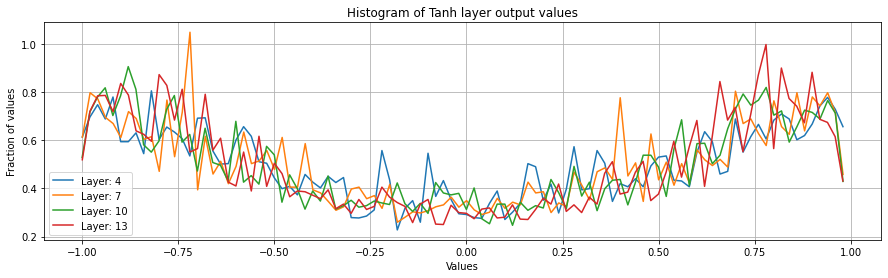

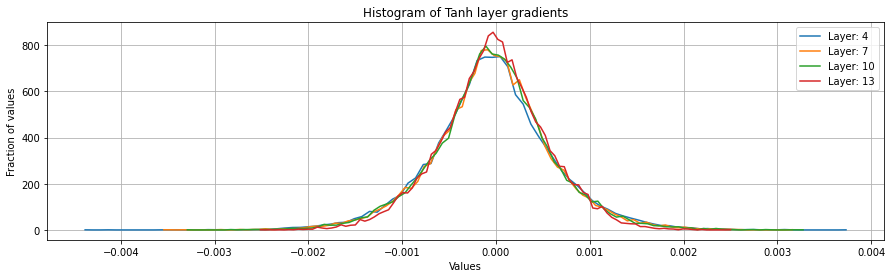

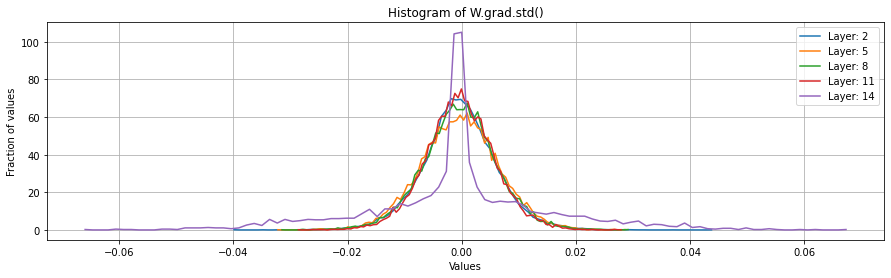

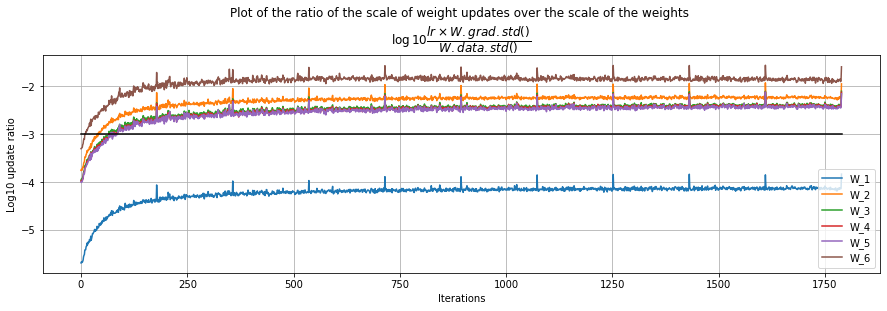

In [39]:
disp("<h3>Kaiming He but with batch norm</h3>")
experiment(
    lr=0.1,
    lin_wt_gain=(5 / 3),
    max_sub_iter=np.inf,
    batchnorm=True,
    num_iter=10,
)

## Save figures for blog

In [ ]:
hist_actvns(mdl);
# plt.savefig("/Users/vispers/work/github/psvishnu91.github.io/assets/Images/posts/ml_notes/backprop/activation_hist.png")

In [ ]:
hist_actvn_grads(mdl);
# plt.savefig("/Users/vispers/work/github/psvishnu91.github.io/assets/Images/posts/ml_notes/backprop/activation_grad_hist.png")

In [ ]:
hist_weight_grads(mdl);
# plt.savefig("/Users/vispers/work/github/psvishnu91.github.io/assets/Images/posts/ml_notes/backprop/weight_grad_hist.png")

In [ ]:
plot_update_ratio(wt_update_ratios)
# plt.savefig("/Users/vispers/work/github/psvishnu91.github.io/assets/Images/posts/ml_notes/backprop/update_ratio_hist.png")